<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/EfficientNet_AM_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Attention, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier


# **Define Path**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define directories
train_dir = '/content/drive/MyDrive/DR/Train'
test_dir = '/content/drive/MyDrive/DR/Test'
valid_dir = '/content/drive/MyDrive/DR/Valid'

Mounted at /content/drive


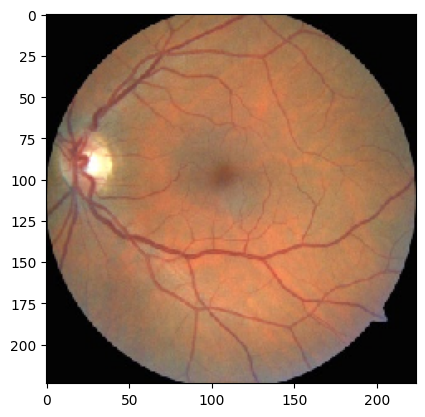

In [3]:
img_path = '/content/drive/MyDrive/DR/Train/0/10.jpg'  # replace with your image path
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
plt.imshow(img)


# **Image Augmentation**

In [4]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=True,  # Vertical flip
    zoom_range=0.2,  # Zoom
    brightness_range=[0.2,1.0]  # Brightness adjustment acting as Gamma correction
)

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_set = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1750 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


# **Feature Extraction**

In [11]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [12]:
# Feature extraction
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)

train_features = feature_extractor.predict(train_set)
valid_features = feature_extractor.predict(valid_set)
test_features = feature_extractor.predict(test_set)

# Flatten extracted features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
valid_features_flat = valid_features.reshape(valid_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Get the labels
train_labels = train_set.classes
valid_labels = valid_set.classes
test_labels = test_set.classes


8/8 [==============================] - 65s 9s/step


# **Machine Learning Classifier**

In [13]:
# SVM
svm_classifier = svm.SVC()
svm_classifier.fit(train_features_flat, train_labels)
svm_predictions = svm_classifier.predict(test_features_flat)

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(train_features_flat, train_labels)
knn_predictions = knn_classifier.predict(test_features_flat)


# **Define Attention Mechanism**

In [14]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.squeeze(tf.tanh(tf.matmul(x, self.W) + self.b), axis=-1)
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)
        output = x * at
        output = tf.reduce_sum(output, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# **Add the Attention Layer to Pre-trained Model**

In [15]:
attention_model = Sequential()
attention_model.add(base_model)
attention_model.add(AttentionLayer())
attention_model.add(Flatten())
attention_model.add(Dense(5, activation='softmax'))

# **Compile the model**

In [16]:
attention_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# **Save the model**

In [17]:
attention_model.save("newmodel_am_ks.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **About the Model**

In [18]:
attention_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 attention_layer (Attention  (None, 7, 1280)           1287      
 Layer)                                                          
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dense (Dense)               (None, 5)                 44805     
                                                                 
Total params: 4095663 (15.62 MB)
Trainable params: 4053640 (15.46 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


# **Train the model**

In [19]:
history = attention_model.fit(train_set, validation_data=valid_set, epochs=10)


Epoch 1/10
55/55 [==============================] - 606s 10s/step - loss: 1.2467 - accuracy: 0.4811 - val_loss: 1.6628 - val_accuracy: 0.2000
Epoch 2/10
55/55 [==============================] - 563s 10s/step - loss: 0.7948 - accuracy: 0.6646 - val_loss: 5.8108 - val_accuracy: 0.2000
Epoch 3/10
55/55 [==============================] - 562s 10s/step - loss: 0.7227 - accuracy: 0.7063 - val_loss: 28.5694 - val_accuracy: 0.2000
Epoch 4/10
55/55 [==============================] - 555s 10s/step - loss: 0.7307 - accuracy: 0.7000 - val_loss: 15.5023 - val_accuracy: 0.2000
Epoch 5/10
55/55 [==============================] - 538s 10s/step - loss: 0.6133 - accuracy: 0.7411 - val_loss: 5.1058 - val_accuracy: 0.2000
Epoch 6/10
55/55 [==============================] - 546s 10s/step - loss: 0.5715 - accuracy: 0.7617 - val_loss: 3.1613 - val_accuracy: 0.2000
Epoch 7/10
55/55 [==============================] - 547s 10s/step - loss: 0.5671 - accuracy: 0.7726 - val_loss: 2.4274 - val_accuracy: 0.2000
Epoc

# **Performance metrics**

In [20]:
# Make predictions
y_pred = attention_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 19s 2s/step


In [21]:
# Compute confusion matrix
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 0  0  0 50  0]
 [ 0  0  0 50  0]
 [ 0  0  0 50  0]
 [ 0  0  0 50  0]
 [ 0  0  0 50  0]]


<Axes: >

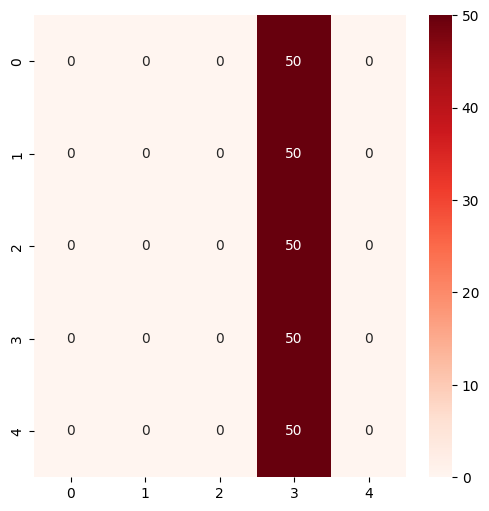

In [26]:
# Create heatmap from confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d",
            xticklabels=train_set.class_indices.keys(),
            yticklabels=train_set.class_indices.keys(), ax=ax)

In [27]:
# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

In [28]:
class_name = train_set.class_indices
print(class_name)
# Compute classification report
report = classification_report(test_set.classes, y_pred, target_names=class_name)
print('Classification Report:')
print(report)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.20      1.00      0.33        50
           4       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04      0.20      0.07       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
precision = precision_score(test_set.classes, y_pred, average='macro')
recall = recall_score(test_set.classes, y_pred, average='macro')
accuracy = accuracy_score(test_set.classes, y_pred)
f1 = f1_score(test_set.classes, y_pred, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)
print('F1 Score:', f1)

Precision: 0.04
Recall: 0.2
Accuracy: 0.2
F1 Score: 0.06666666666666668


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import classification_report

print('SVM Classification Report:')
print(classification_report(test_labels, svm_predictions))

print('KNN Classification Report:')
print(classification_report(test_labels, knn_predictions))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.20      1.00      0.33        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04      0.20      0.07       250

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.20      1.00      0.33        50
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif